## Getting QuTip Down

In [85]:
import qutip as qt
import qutip.states as qts
import qutip.operators as qto
import qutip.states as qts
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import seaborn as sns
from functools import reduce

sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (nqubit_1pauli, nqubit_2pauli, loadAandB, dict_to_qutip,
                       make_numeric_schedule, get_numeric_H, time_interpolation)

In [86]:
# Form a dictionary representation of a problem and create an anneal_schedule
dictparams = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): -0.1}
problem = DictRep(H = dictparams, qpu = 'dwave', vartype = 'ising', encoding = "logical")
schedule = make_numeric_schedule(.1, **{'ta': 1})
times = schedule[0]
svals = schedule[1]

In [87]:
# Create H(t)
processor_data = loadAandB()
sch_ABfuncs = time_interpolation(schedule, processor_data)
Hs = get_numeric_H(problem)
A = sch_ABfuncs['A(t)']
B = sch_ABfuncs['B(t)']
HX = Hs['HX']
HZ = Hs['HZ']
# Define H(t)
H = lambda t : A(t)*HX + B(t)*HZ

# Define list_H for QuTiP
list_H = [[HX, A], [HZ, B]]

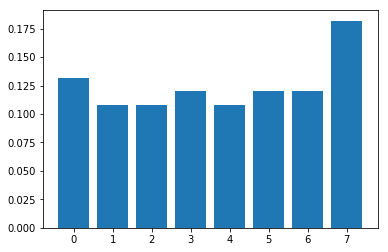

In [88]:
results = qt.sesolve(list_H, H(0).groundstate()[1], times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()

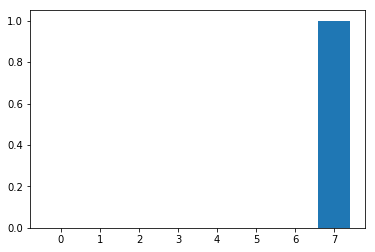

In [99]:
# exact diagonlization of ground-state at the end
gs = H(times[-1]).groundstate()[1]
gs_amps = np.array([abs(gs[i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gs_amps.flatten())
plt.show()

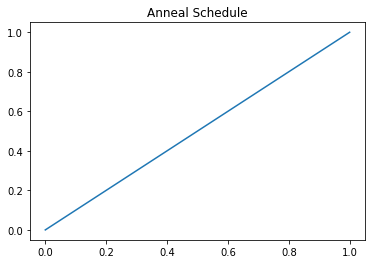

In [89]:
plt.plot(times, svals)
plt.title("Anneal Schedule")
plt.show()

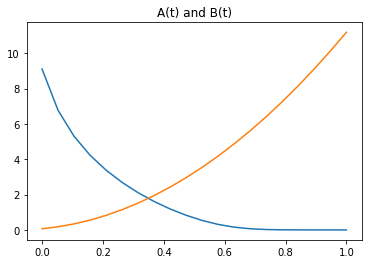

In [90]:
plt.plot(times, A(times))
plt.plot(times, B(times))
plt.title("A(t) and B(t)")
plt.show()